In [2]:
import gymnasium as gym
import numpy as np
import random

In [25]:
env = gym.make('CartPole-v1')

sample_state = env.reset()[0]
print(sample_state)

print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))
print(env.step(0))

[ 0.0272153   0.01512849  0.03543675 -0.02604767]
(array([ 0.02751787, -0.18048327,  0.03491579,  0.27760196], dtype=float32), 1.0, False, False, {})
(array([ 0.0239082 , -0.3760855 ,  0.04046783,  0.5810896 ], dtype=float32), 1.0, False, False, {})
(array([ 0.01638649, -0.5717504 ,  0.05208962,  0.886241  ], dtype=float32), 1.0, False, False, {})
(array([ 0.00495148, -0.7675393 ,  0.06981444,  1.1948335 ], dtype=float32), 1.0, False, False, {})
(array([-0.0103993 , -0.96349233,  0.09371112,  1.5085558 ], dtype=float32), 1.0, False, False, {})
(array([-0.02966915, -1.159617  ,  0.12388223,  1.8289627 ], dtype=float32), 1.0, False, False, {})
(array([-0.05286149, -1.3558749 ,  0.16046149,  2.1574218 ], dtype=float32), 1.0, False, False, {})
(array([-0.07997899, -1.5521667 ,  0.20360991,  2.4950504 ], dtype=float32), 1.0, False, False, {})


In [28]:
import time
env = gym.make('CartPole-v1')
env.reset()
print("READY!")
time.sleep(2)

score = 0

while True:
    # env.step 진행 : 왼쪽으로만 힘을 준 경우!!
    _, _, done, _, _ = env.step(0)

    if done:
        print("GAME OVER! score: {}".format(score))
        time.sleep(1)
        break

    score += 1
    time.sleep(0.1)

READY!
GAME OVER! score: 8


In [30]:
from keras.layers import Dense
from keras import Model 
import tensorflow as tf

from collections import deque

In [38]:
# 뇌 !!!!!
class DQN(Model):
    def __init__(self):
        super(DQN, self).__init__()
        self.d1 = Dense(64, input_dim=4, activation='relu') #입력층 : 4개 - 32
        self.d2 = Dense(2, activation='linear') #출력층 : 2개 : 0,1 : 0은 왼쪽, 1은 오른쪽
        self.optimizer = tf.keras.optimizers.Adam(0.01) #옵티마이저 : Adam, 학습률 : 0.01

    def call(self, x): #predict : 모델이 출력할 때 쓰는 함수
        x = self.d1(x)
        x = self.d2(x)
        return x
    
model = DQN() #모델 생성

In [40]:
env = gym.make('CartPole-v1') #환경 생성

sample_state = env.reset()[0]
print(sample_state)
sample_state = sample_state.reshape(1,4) # 1x4로 변환
print(sample_state) #모델에 넣어서 출력

print(model.call(sample_state)) #학습이 되어있지 않은 뇌한테 묻기
print(np.argmax(model.call(sample_state))) #더 큰 Q값을 가지는 액션(인덱스)

[ 0.04755724  0.02760814  0.00039424 -0.043462  ]
[[ 0.04755724  0.02760814  0.00039424 -0.043462  ]]
tf.Tensor([[-0.01168137 -0.02519012]], shape=(1, 2), dtype=float32)
0


In [49]:
#카트폴 시작

memory = deque(maxlen=10000)
episode = 400
step = 400
score = []

for i in range(episode):
    state = env.reset()[0]
    state = state.reshape(1,4)

    eps = np.exp(-i/50) #그냥 에피소드가 진행될 때 마다 감소하는 감소함수 정도로 생각하시면 됩니다.

    for t in range(step):
        #epsilon-greedy
        if np.random.rand() < eps:
            action = env.action_space.sample() #랜덤으로 action space에서 뽑아줌
        else:
            action = np.argmax(model.call(state)) #모델이 출력한 Q값 중 가장 큰 값의 인덱스를 action으로
    
        next_state, reward, done, _, _ = env.step(action) 

        if done :
            reward = -5


        next_state = next_state.reshape(1,4)
        memory.append((state, action, reward, next_state, done)) #메모리에 저장 : 메모리 : 교재는 학습할 때 쓸 것!
        state = next_state

        if done or t==step-1:
            print("Episode : {}, Score : {}".format(i, t))
            score.append(t)
            break

    if i > 50:
        minibatch = random.sample(memory, 32)
        states = np.array([x[0][0] for x in minibatch]) #32x4
        actions = np.array([x[1] for x in minibatch]) #32
        rewards = np.array([x[2] for x in minibatch]) #32
        next_states = np.array([x[3][0] for x in minibatch]) #32x4
        dones = np.array([x[4] for x in minibatch]) #32

        target = model.call(states).numpy() #32x2
        target[range(32), actions] = rewards + (1-dones) * 0.95 * np.max(model.call(next_states).numpy(), axis=1) #32x1 #Q - 벨만방정식

        with tf.GradientTape() as tape: #경사하강법
            loss = tf.reduce_mean(tf.square(target - model.call(states)))
            grads = tape.gradient(loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))






Episode : 0, Score : 34
Episode : 1, Score : 24
Episode : 2, Score : 42
Episode : 3, Score : 25
Episode : 4, Score : 9
Episode : 5, Score : 24
Episode : 6, Score : 19
Episode : 7, Score : 28
Episode : 8, Score : 65
Episode : 9, Score : 14
Episode : 10, Score : 21
Episode : 11, Score : 24
Episode : 12, Score : 25
Episode : 13, Score : 31
Episode : 14, Score : 24
Episode : 15, Score : 49
Episode : 16, Score : 43
Episode : 17, Score : 41
Episode : 18, Score : 51
Episode : 19, Score : 56
Episode : 20, Score : 84
Episode : 21, Score : 17
Episode : 22, Score : 49
Episode : 23, Score : 46
Episode : 24, Score : 39
Episode : 25, Score : 49
Episode : 26, Score : 71
Episode : 27, Score : 113
Episode : 28, Score : 69
Episode : 29, Score : 92
Episode : 30, Score : 85
Episode : 31, Score : 67
Episode : 32, Score : 64
Episode : 33, Score : 20
Episode : 34, Score : 19
Episode : 35, Score : 97
Episode : 36, Score : 72
Episode : 37, Score : 18
Episode : 38, Score : 85
Episode : 39, Score : 155
Episode :

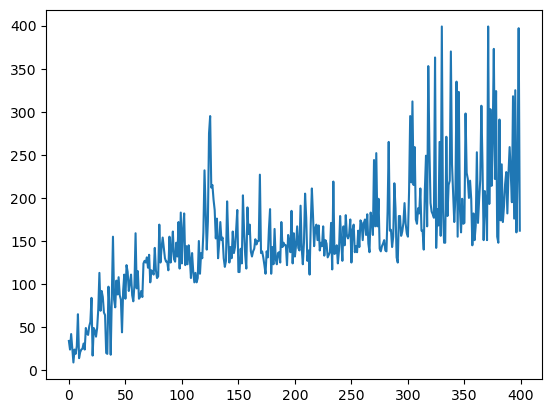

In [50]:
import matplotlib.pyplot as plt

plt.plot(score)
plt.show()